# Mesa ABM of the Keep Threshold Relay

### Simulation notes and instructions

Notes:
* Nodes are created simulataneously using the Mesa SimultaneousActivation scheduler
* The nodes go through a bootstrap phase based on Antonio's diagram. They can only form groups if they are in the mainloop forked state.
* Relay requests are currently bernoulli trials
* Each step could be assumed to be a block
* Singature events are modeled by default as asynchronous with a step delay to mimick the block delay
* We assume that 1 node = 1 staker

Instructions:
1. Change variables
2. Click on the restart and run kernel icon for ipython


In [1]:
import random
import datetime
import numpy as np
import pandas as pd
import agent
import model
import matplotlib.pyplot as plt

**Initialize Variables**

The following variables determine how the simulation will perform. Each variable has a comment beside it describing what it means. We suggest you change individual variables one at a time and run the simulation each time to see how they impact the simulation.

In [2]:
# Group & Signature Parameters
group_size = 100 # number of virtual stakers in a group - nodes to stakers is a 1-many relationship
nodes = 100 # total number of nodes (assume 1 node = 1 staker)
active_group_threshold =10 # number of active groups to bootstrap at start
min_nodes = 40 # min number of nodes that must be online so as to increase the likelihood of lower max ownership
max_malicious_threshold = 0.30 # % of malicious node ownership needed to sign (used to determine dominator/lynchpin)
signature_delay = 2 # lambda for poisson distribution used to generate a delay before the signature is executed
group_expiry = 14 # number of steps after which a group expires
Misbehaving_nodes = 10 # percent of nodes misbehaving during dkg
dkg_block_delay = 14 # blocks needed to run DKG
compromised_threshold = 0.25 # malicious > threshold = compromised
failed_signature_threshold = 0.6 # % of offline nodes causing a signature to fail

#Node parameters
node_failure_percent = 10 # % of times nodes fail and have to reconnect
node_death_percent = 5 # % of time nodes fail and do not reconnect
node_connection_delay = 5 # max delay for a node to connect or reconnect after failure
node_mainloop_connection_delay = 3 # max delay for a node to fork or refork mainloop after failure
node_ownership_params = [0,1] # assign median and mean for normal distribution of node ownership

#Model Parameters
log_filename = 'master_sim.log'
run_number = 0
steps = 1000 #blocks

**Creating the virtual staker distributions**

The code below assignes virtual stakers to each node based on the specified distribution provided by an excel file. The values are converted to int. The values are also proportional reduced by a factor of 10000 to reduce computation time.

In [3]:
distribution_data = pd.read_excel('~/Downloads/token_distribution.xlsx')
ticket_distribution = []
for value in distribution_data.values.tolist():
    if value[0] > 0 :
        ticket_distribution.append(int(value[0]/10000))

**Initialize the model**

Intializing the model and agents

Text(0.5, 1.0, 'Virtual Staker Distribution')

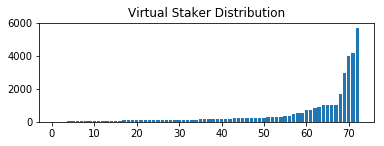

In [4]:
nodes = len(ticket_distribution)
ticket_distribution.sort()
x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

Text(0.5, 1.0, 'Virtual Staker Cumulative Distribution')

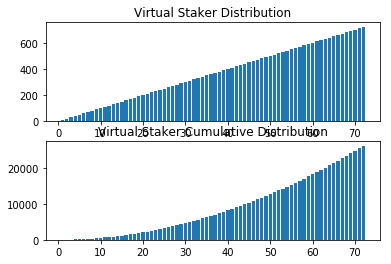

In [5]:
# Linear y = m * (x + 1) since indices start from 0
ticket_distribution = np.zeros(nodes) 

for i in range (0, nodes):
    ticket_distribution[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

cdf_L02=model.create_cdf(nodes,ticket_distribution)
plt.subplot(2, 1, 2)
plt.bar(x, cdf_L02)
plt.title("Virtual Staker Cumulative Distribution")

Text(0.5, 1.0, 'Virtual Staker Distribution')

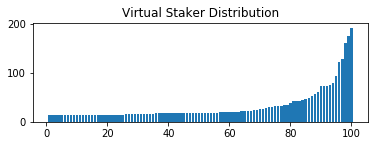

In [6]:
distribution_data = pd.read_excel('~/Downloads/eth_distr.xlsx')
ticket_distribution = []
for value in distribution_data.values.tolist():
    if value[0] > 0 :
        ticket_distribution.append(int(value[0]*10000))
        
nodes = len(ticket_distribution)
ticket_distribution.sort()
x = np.linspace(1,nodes,nodes)
plt.subplot(2, 1, 1)
plt.bar(x, ticket_distribution)
plt.title("Virtual Staker Distribution")

In [7]:
beacon_model = model.Beacon_Model(nodes, ticket_distribution, 
                                  active_group_threshold, 
                                  group_size, 
                                  max_malicious_threshold, 
                                  group_expiry, 
                                  node_failure_percent, 
                                  node_death_percent, 
                                  signature_delay,
                                  min_nodes,
                                  node_connection_delay,
                                  node_mainloop_connection_delay,
                                  log_filename,
                                  run_number,
                                  Misbehaving_nodes,
                                  dkg_block_delay,
                                  compromised_threshold,
                                  failed_signature_threshold,
                                  node_ownership_params
                                 )


creating nodes


**Stepping throgh the model**

The model steps through and changes the state of each agent at each step. The MESA data collector collects data on agent and model state at each step.

In [8]:
import time

active_group_size = []
signature_failures = []
start_time = time.time()
for i in range (steps):
    beacon_model.step()
print("--- %s seconds ---" % (time.time() - start_time))


model_data = beacon_model.datacollector.get_model_vars_dataframe() 
agent_data = beacon_model.datacollector.get_agent_vars_dataframe()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


--- 7.305734157562256 seconds ---


**Number of Active Groups**

The plot below shows a histogram of the number of active groups available at each step. Active groups increase due to the registration of new groups, which occurs when a relay entry is requested. Active groups remain active for the number of steps set by the group_expiry parameter. 

Text(0, 0.5, 'frequency')

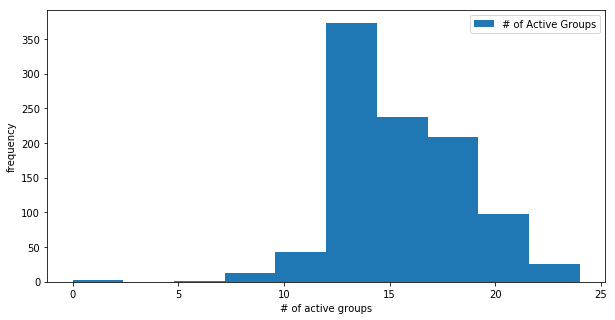

In [9]:
model_data.plot(kind='hist', legend = True, y = ['# of Active Groups'], figsize = (10,5))
plt.xlabel("# of active groups")
plt.ylabel("frequency")

**Active Groups, Node, and Signatures**

Active Groups: Active groups available at every step. Same as above active groups are created when a relay entry occurs and a group is successfully registered

Active Nodes: Active nodes are nodes in the staked status. This is based on the node state diagram provided by Antonio

Number of Signatures: Signatures completed in aggregate including those considered to have failed based on the number of offline nodes.

<function matplotlib.pyplot.show(*args, **kw)>

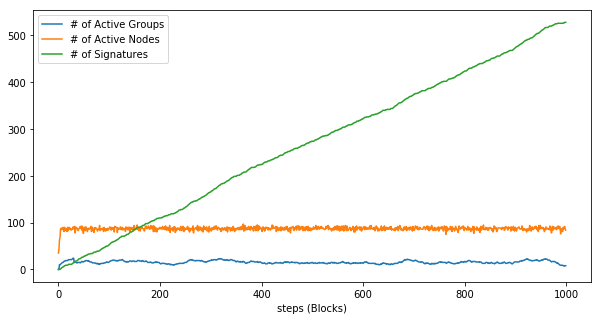

In [10]:
model_data.plot(kind='line', legend = True, y = ['# of Active Groups', '# of Active Nodes', '# of Signatures' ], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


**Median Malicious, Dominator, & Failure %**

Median Malicious Group % : We take the poppulation of groups and calculate median malicious ownership of the groups from the malicious % property of the group agent. The malicious ownership % is the percentage of the groups virtual stakers owned by malicious nodes.

Median Dominator Group % : Similar to above we take the Dominator % property of each group and find the median at each step. The Dominator % = %owned by 1 node + Offline nodes

Median Failure % : Signature failures are determined by the offline % evaluated against the failed signature threshold set above. Signatures with % of nodes offline > than the threshold are considered to have failed. Once again we calculate the median at each step.

<function matplotlib.pyplot.show(*args, **kw)>

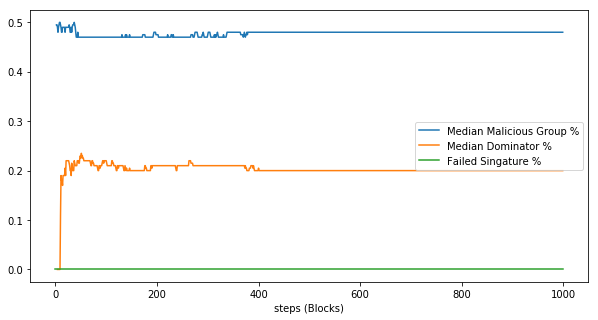

In [11]:
model_data.plot(kind='line', legend = True, y = ['Median Malicious Group %','Median Dominator %', 'Failed Singature %'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show

**Compromised Groups & Dominated Signatures**

% Compromised Groups: % of total groups designated as compromised based on the compromised threshold set above

% Dominated signatures: % of signatures desiganted as dominated based on the max malicious threshold set above

<function matplotlib.pyplot.show(*args, **kw)>

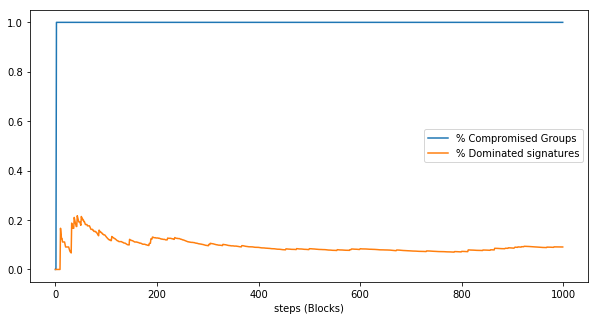

In [12]:
model_data.plot(kind='line', legend = True, y = ['% Compromised Groups','% Dominated signatures'], figsize = (10,5))
plt.xlabel("steps (Blocks)")
plt.show


In [13]:

data = agent_data[(agent_data['Type']=='node')]# & (agent_data['Step']==400) ]
np.shape(agent_data)
data.loc[100]

#data['Ownership Distribution'][3]


,ID,Type,Node Status (Connection_Mainloop_Stake),Status,Malicious,DKG Block Delay,Ownership Distribution,Malicious %,Offline %,Dominator %,Owner
AgentID,,,,,,,,,,,
0,0,node,connected,None,True,NaN,None,NaN,NaN,NaN,47.0
1,1,node,connected,None,True,NaN,None,NaN,NaN,NaN,60.0
2,2,node,connected,None,False,NaN,None,NaN,NaN,NaN,29.0
3,3,node,connected,None,False,NaN,None,NaN,NaN,NaN,64.0
4,4,node,connected,None,True,NaN,None,NaN,NaN,NaN,43.0
5,5,node,connected,None,True,NaN,None,NaN,NaN,NaN,47.0
6,6,node,connected,None,True,NaN,None,NaN,NaN,NaN,55.0
7,7,node,not connected,None,True,NaN,None,NaN,NaN,NaN,46.0
8,8,node,connected,None,True,NaN,None,NaN,NaN,NaN,46.0


In [14]:
model_data.loc[50:]

,# of Active Groups,# of Active Nodes,# of Signatures,Median Malicious Group %,% Compromised Groups,Median Dominator %,% Dominated signatures,Failed Singature %
50,17,84,28,0.47,1.0,0.225,0.178571,0.0
51,17,90,28,0.47,1.0,0.235,0.214286,0.0
52,18,90,29,0.47,1.0,0.230,0.206897,0.0
53,18,83,29,0.47,1.0,0.230,0.206897,0.0
54,19,91,30,0.47,1.0,0.225,0.200000,0.0
55,19,89,30,0.47,1.0,0.225,0.200000,0.0
56,19,87,31,0.47,1.0,0.220,0.193548,0.0
57,18,81,31,0.47,1.0,0.220,0.193548,0.0
58,18,85,32,0.47,1.0,0.220,0.187500,0.0
59,19,88,33,0.47,1.0,0.220,0.181818,0.0


Change node to virtual staker and add properties to indicate node and ownership
Change as per PR
convert xl to csv



In [15]:
x ={i : np.random.randint(100)<30 for i in range(10)}
    
x

{0: True,
 1: False,
 2: False,
 3: True,
 4: False,
 5: True,
 6: False,
 7: False,
 8: False,
 9: False}

In [16]:
import math

y = 43
y = math.ceil(y/10)
y



5